In [3]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt

data_path = "/media/ruben/Elements/PhD/data/hansard/lemmatized_pm"

plotting.style(12)

In [2]:
# Determine number of unique speakers using a term in a given year

def unique_speakers(word,year):
    grp = f'egrep -iE "{word}"  /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*{year}* | cut -f 8'
    output = subprocess.check_output(grp,shell=True).decode('utf-8')
    output = [l for l in output.split('\n')]
    return output

d = []
for year in range(1957,1985):
    d.append([year,len(set(unique_speakers("bureaucracy",year)))])
d = pd.DataFrame(d,columns=['year','unique_speakers'])

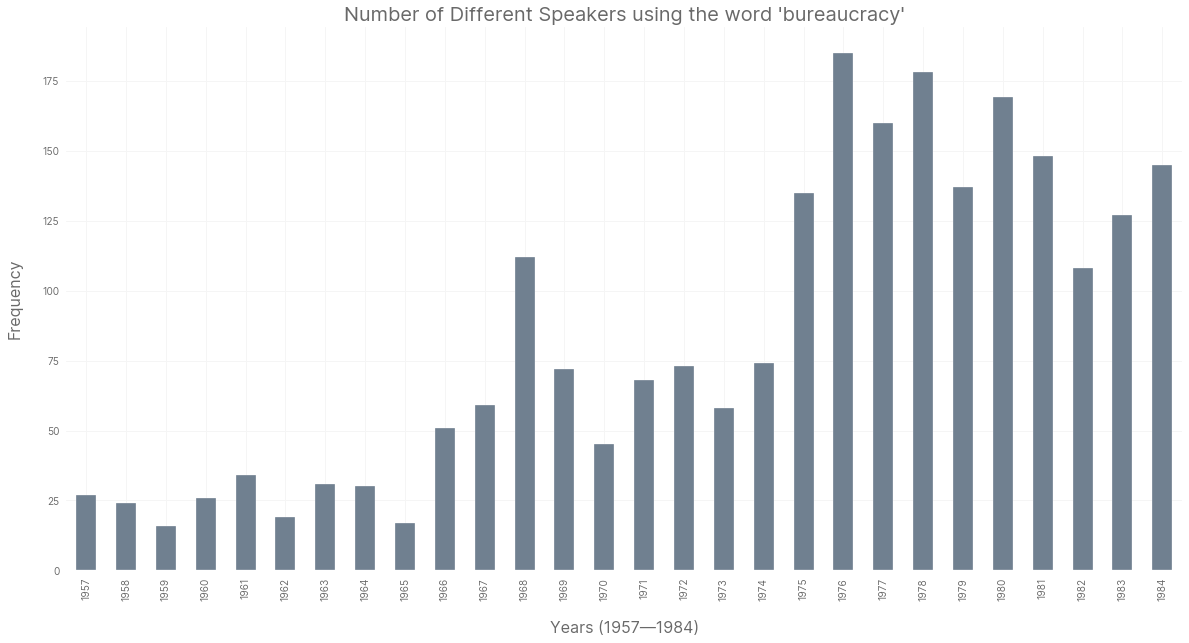

In [25]:
fig, ax = plt.subplots(figsize=(4,2))
d.plot.bar(x='year',y='unique_speakers',figsize=(20,10),stacked=True,color='slategrey',ax=plt.gca(),legend=False)
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Frequency",labelpad=20)
plt.title("Number of Different Speakers using the word 'bureaucracy'")
plt.savefig("/home/ruben/Documents/GitHub/CrisisBureaucracy/results/freq-unique-speakers-bureaucracy.png",dpi=250)
plt.show()

In [88]:
# Inspect Peak Speakers
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/bureaucracy-sentences-full.tsv',sep='\t')
df['party'] = df.id.str.split('-').str[-1]
df['year'] = df.id.str.split('-').str[1].astype(int)
df['speaker_id'] = df.id.str.split('-').str[0].astype(str)
df['window'] = utils.preprocess_(df['window'])
df['date'] = df.id.str.split('.').str[0].str.split('-').str[1:].str.join('-')
df.columns = ["text" if c == 'window' else c for c in df.columns]

df_g = df[['party','year']]
df_g['n'] = 1
df_g = df_g.groupby(['party','year']).sum().reset_index().pivot(index='year',columns='party',values='n').reset_index().fillna(0)[['year','conservative','labour']]

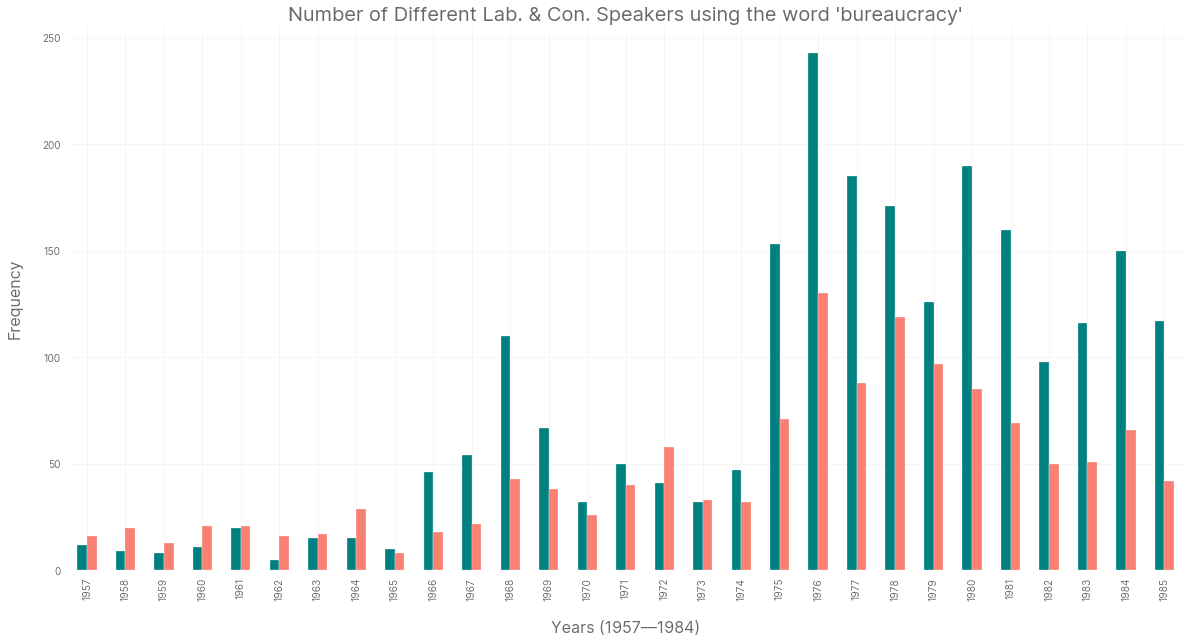

In [18]:
fig, ax = plt.subplots(figsize=(4,2))
df_g.plot.bar(x='year',y=['conservative','labour'],figsize=(20,10),stacked=False,color=['teal','salmon'],ax=plt.gca(),legend=False)
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Frequency",labelpad=20)
plt.title("Number of Different Lab. & Con. Speakers using the word 'bureaucracy'")
plt.savefig("/home/ruben/Documents/GitHub/CrisisBureaucracy/results/freq-unique-speakers-party-bureaucracy.png",dpi=250)
plt.show()

In [130]:
dict_speaker_year = {y:{"c":Counter(df[(df.year == y) & (df.party == 'conservative')]['speaker_id']),"l":Counter(df[(df.year == y) & (df.party == 'labour')]['speaker_id'])} for y in range(1957,1985)}

In [210]:
def plot_(y,party, ax=None, **kwargs): 
    ax = ax or plt.gca()
    # fig,ax = plt.subplots(figsize=(6,2))
    d = dict_speaker_year[y]
    y1 = list(d[party].values())
    #y2 = list(d['c'].values())
    
    if party == 'l':
        c = 'salmon'
    if party == 'c':
        c = 'teal'
    pl = ax.hist(x=y1, bins=list(range(0,21)), color=c, alpha=1, rwidth=0.85,label='Labour', **kwargs)
    #plt.hist(x=y2, bins=list(range(0,21)), color='teal', alpha=0.5, rwidth=0.85,label='Conservative')
    plt.xticks(list(range(0,21)))
    plt.ylim(0,50)
    #plt.title(str(y),fontsize=20)
    #plt.show()
    return pl
    
def plt_year(y):
    fig, (ax1, ax2) = plt.subplots(2)
    plot_(y,'l',ax1)
    plot_(y,'c',ax2)
    plt.show()

In [122]:
def load_txt(id_):
    date = "-".join(id_.split('-')[1:])[:10]
    t = pd.read_csv(f'/media/ruben/Elements/PhD/data/hansard/flattened_pm/uk.proc.d.{date}.txt',sep='\t')
    line_id = "-".join(id_.split('-')[1:-1])
    return t[t['id'] == f'uk.proc.d.{line_id}'].reset_index(drop=True)['text'][0]

def load_speaker(id_,year):
    with open(f'/media/ruben/Elements/PhD/data/hansard/raw/pm/members/uk.m.{id_}.xml','r') as f:
        c = f.read()
    s = bs(c)
    print('Name: ',s.find('full').text, "in the year",year,'\n--------------------')
    tdf = df[(df.speaker_id == id_) & (df.year == year)].reset_index(drop=True)

    for c,u in enumerate(tdf['id']):
        print('\t',tdf['date'][c],'\t',load_txt(u))
        print('\t------------')
    return

In [230]:
y = 1974
t = dict_speaker_year[y]['c'].most_common(3)

for i in t:
    load_speaker(i[0],y)

Name:  Lord Cormack in the year 1974 
--------------------
	 1974-06-12 	 Think of the massive bureaucracy that will be needed to enforce the Bill. One does not need to do more than refer to the statement which the right hon. Lady made this afternoon and to consider certain items on which manufacturers will concentrate their promotional activity. It is not the sphere of government to go poking into every High Street shop trying to influence people's taste and distort the market. [HON. MEMBERS: "Distort?"] Hon. Members may scoff, but what is inherently so much better about fish fingers than other forms of protein? What is so much better about instant coffee than tea bags, which incidentally I do not see on the list? Margarine is on the list but some other forms of fat are not. And so we can go on.
	------------
	 1974-06-12 	 Then we have the items which will be on continuous offer, such as matches—one line—and toilet soap, again one line. Surely that is a distortion of the market. It i

In [28]:
# Determine number of unique speakers using a term in a given year

def pr(word,year):
    grp = f'egrep -iE "{word}"  /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*{year}* | cut -f 1'
    output = subprocess.check_output(grp,shell=True).decode('utf-8')
    output = [l.split("uk.proc.d.")[1][:10] if l != '' else 'nan' for l in output.split('\n')]
    return [x for x in output if x != "nan"]

d = []
for year in range(1957,1985):
    p = pr("bureaucracy",year)
    d.append([year,len(set(p)) / len(p)])
d = pd.DataFrame(d,columns=['year','unique_speakers'])

In [99]:
# Find speakers using a specific term
from IPython.core.display import display, HTML

def find(terms=[],year=1957,party='',sample_size=100):
    r = subprocess.check_output(f'egrep -iE "{"|".join(terms)}"  {data_path}/*{year}*',shell=True).decode('utf-8')
    r = [t.split('\t') for t in r.split('\n')]
    r = pd.DataFrame(r)
    r.columns = [str(x) for x in r.columns]
    if party != '':
        r = r[r['9'] == party].reset_index(drop=True)
    r = r.dropna()
    r['date'] = [str(i).split('.')[3] for i in r['2']]
    r['date'] = pd.to_datetime(r['date'], format='%Y-%m-%d')
    r = r.sort_values('date').reset_index(drop=True)
    return r

def print_text(d,terms=[],sample_size=100):
    for t in terms:
        d['11'] = [str(x).replace(t,f'<b>{t}</b>') for x in d['11']]
    if len(d) >= sample_size:
        d = d.sample(sample_size).reset_index(drop=True)
    d = d.sort_values('date').reset_index(drop=True)
    for c,i in d.iterrows():
        if i['0']:
            print(i['8']+' || '+i['9'] + " || " + i['2'].split('.')[3])
            op = i['1']+'<br>'
        
            display(HTML(op))
            print('----------------')

def run(terms,year,party,sample_size=100):
    d = find(terms,year,party,sample_size)
    print_text(d,terms)
    return d

In [116]:
d = run(terms=["managerial"],year="1976",party='',sample_size=1000)

Mr. Buchanan-Smith || Conservative || 1976-01-14


----------------
Mr. Fletcher || Labour || 1976-01-21


----------------
The Financial Secretary to the Treasury (Mr. Robert Sheldon) || Labour || 1976-01-22


----------------
The Under-Secretary of State for the Environment (Mr. Ernest Armstrong) || Labour || 1976-03-01


----------------
Mr. Julian Critchley || Conservative || 1976-03-02


----------------
Mr. Horam || Conservative || 1976-03-05


----------------
Mr. Horam || Conservative || 1976-03-05


----------------
Mr. Grylls || Conservative || 1976-03-05


----------------
The Minister of State, Department of Industry (Mr. Gregor Mackenzie) || Labour || 1976-03-05


----------------
Mr. Esmond Bulmer || Conservative || 1976-03-12


----------------
Mr. Esmond Bulmer || Conservative || 1976-03-12


----------------
Mr. Raison || Conservative || 1976-03-17


----------------
Mr. Freeson || Labour || 1976-03-17


----------------
Mr. Freeson || Labour || 1976-03-17


----------------
The Minister for Transport (Dr. John Gilbert) || Labour || 1976-03-17


----------------
Mr. Mackenzie || Labour || 1976-03-18


----------------
Mr. Mackenzie || Labour || 1976-03-18


----------------
The Under-Secretary of State for the Environment (Mr. Ernest Armstrong) || Labour || 1976-03-23


----------------
Mr. J. Enoch Powell || Conservative || 1976-04-01


----------------
Mr. John Garrett || Labour || 1976-04-02


----------------
Mr. Garrett || Labour || 1976-04-02


----------------
Mr. Geoffrey Robinson || Labour || 1976-04-08


----------------
Mr. Frederick Willey || Labour || 1976-04-09


----------------
Mr. Roy Hughes || Labour || 1976-04-26


----------------
Mr. Geoffrey Pattie || Conservative || 1976-04-29


----------------
Mr. Esmond Bulmer || Conservative || 1976-05-03


----------------
Mr. Bulmer || Conservative || 1976-05-03


----------------
Mr. Pym || Conservative || 1976-05-04


----------------
Mr. Onslow || Conservative || 1976-05-06


----------------
Mr. Onslow || Conservative || 1976-05-06


----------------
Mr. MacGregor || Conservative || 1976-05-11


----------------
Mr. Norman Lamont || Conservative || 1976-05-11


----------------
Mr. MacGregor || Conservative || 1976-05-11


----------------
Mr. MacGregor || Conservative || 1976-05-11


----------------
Sir G. Howe || Conservative || 1976-05-11


----------------
Mr. Nott || Conservative || 1976-05-17


----------------
Mr. Rees || Conservative || 1976-05-17


----------------
Mr. Varley || Labour || 1976-05-17


----------------
Mr. Freeson || Labour || 1976-05-18


----------------
Mr. Heseltine || Conservative || 1976-05-19


----------------
Mr. Brian Sedgemore || Labour || 1976-05-19


----------------
Mr. John Stokes || Conservative || 1976-06-09


----------------
The Under-Secretary of State for Trade (Mr. Clinton Davis) || Labour || 1976-06-17


----------------
Mr. Kinnock || Labour || 1976-06-21


----------------
Mr. Orme || Labour || 1976-06-25


----------------
Mr. Ennals || Labour || 1976-06-29


----------------
Mr. Foot || Labour || 1976-06-29


----------------
Mr. Litterick || Labour || 1976-07-07


----------------
Mr. Litterick || Labour || 1976-07-07


----------------
Mr. Thorne || Labour || 1976-07-13


----------------
Mr. Gow || Conservative || 1976-07-14


----------------
Mr. Robert Sheldon || Labour || 1976-07-14


----------------
Mr. King || Conservative || 1976-07-19


----------------
Mr. Alan Williams || na || 1976-07-19


----------------
Mr. J. Enoch Powell || Conservative || 1976-07-23


----------------
Mr. James Kilfedder || Ulster Popular Unionist || 1976-07-23


----------------
Mr. Powell || Conservative || 1976-07-23


----------------
Mr. Heseltine || Conservative || 1976-07-28


----------------
Mr. Frederick Willey || Labour || 1976-07-28


----------------
Mr. Ian Lloyd || Conservative || 1976-07-28


----------------
Mr. Ian Lloyd || Conservative || 1976-07-28


----------------
Mr. Willey || Labour || 1976-07-28


----------------
Mr. Heseltine || Conservative || 1976-07-29


----------------
Mr. Atkinson || Labour || 1976-08-02


----------------
Mr. Robinson || Labour || 1976-08-03


----------------
The Minister of State, Department of Education and Science (Mr. Gerry Fowler) || Labour || 1976-08-06


----------------
Mr. J. Enoch Powell || Conservative || 1976-10-26


----------------
Mr. Wigley || Plaid Cymru || 1976-11-05


----------------
Mr. Gordon Wilson || Scottish National Party || 1976-11-11


----------------
The Secretary of State for Transport (Mr. William Rodgers) || Labour || 1976-11-12


----------------
The Secretary of State for Transport (Mr. William Rodgers) || Labour || 1976-11-12


----------------
Mr. Rodgers || Labour || 1976-11-12


----------------
Mr. Walker || Labour || 1976-11-16


----------------
Mr. Swain || unknown || 1976-11-17


----------------
The Prime Minister || Labour || 1976-11-24


----------------
Mr. John Garrett || Labour || 1976-11-25


----------------
Mr. Biffen || Conservative || 1976-11-29


----------------
Mr. Biffen || Conservative || 1976-12-01


----------------
Mr. Biffen || Conservative || 1976-12-01


----------------
Mr. Norman Lamont || Conservative || 1976-12-01


----------------
Mr. John Biffen || Conservative || 1976-12-07


----------------
Mr. Kinnock || Labour || 1976-12-07


----------------
Mr. Kinnock || Labour || 1976-12-07


----------------
Mr. Benn || Labour || 1976-12-13


----------------
Mr. Kilroy-Silk || United Kingdom Independence Party || 1976-12-20


----------------
The Under-Secretary of State for Defence for the Army (Mr. Robert C. Brown) || Labour || 1976-12-23


----------------
